## Model description

This is the simplest model that I have made that is even somewhat accurate, at least when the conditions stay essentially constant.

1. There is an initial number of new infections on the 0th day.
2. Number of new infections grow exponentially, with some constant rate.
3. A fraction (IFR) of new infections are expected to turn into deaths.
4. Deaths occur after an incubation period then a delay time from illness onset to death. These periods have predefined distributions, and the number of expected deaths on a given date is a convolution of the new infection over time with these 2 distributions.
5. Given the number of expected deaths on each day, the number of deaths is modeled as a Poisson process, and fit to the data.

In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

from covid_19.covid_func import gamma_pdf, lognorm_pdf

Data source for Chicago:

https://www.chicago.gov/city/en/sites/covid-19/home/latest-data.html

Pickle file is created in `create_data_pickles.ipynb` notebook.

In [2]:
death_df = pd.read_pickle('../data/chi_deaths.pickle')

In [3]:
death_df.iloc[-10:]

,deaths
2020-04-02,10
2020-04-03,25
2020-04-04,19
2020-04-05,25
2020-04-06,14
2020-04-07,20
2020-04-08,28
2020-04-09,14
2020-04-10,19
2020-04-11,5


In [4]:
# Drop later rows when it appears that they have not been updated fully
death_df = death_df.iloc[:-3]

In [5]:
num_days = len(death_df)

In [6]:
death_array = death_df['deaths']

In [7]:
death_list = list(death_array)

#### Do a convolution

Incubation period from https://www.mdpi.com/2077-0383/9/2/538:

Lognormal distribution with mean 5.6 days, SD 2.8 days.

In [8]:
mean_i = 5.6
sd_i = 2.8

In [9]:
incubation_pdf = lognorm_pdf(mean_i, sd_i)

In [10]:
incubation_array = np.array([incubation_pdf(x) for x in range(num_days)])

Onset-to-death delay from https://www.sciencedirect.com/science/article/pii/S1473309920302437

Gamma function with mean 17.8 days, coefficient of variation 0.45.

In [13]:
mean_d = 17.8
cov_d = 0.45
sd_d = mean_d * cov_d

In [14]:
delay_pdf = gamma_pdf(mean_d, sd_d)

In [15]:
delay_array = np.array([delay_pdf(x) for x in range(num_days)])

Given an array of infections, the number of deaths at a given date is given by a multiplication of the array with matrices of the following form.

In [17]:
def get_matrix_value(time, array):
    if time < 0:
        return 0.
    else:
        return array[time]

In [18]:
incubation_mat = np.array([[get_matrix_value(i - j,
                                        array=incubation_array)
                            for i in range(num_days)]
                           for j in range(num_days)])

It looks like this.

In [19]:
incubation_mat[:5,:5]

array([[0.        , 0.00251436, 0.06388876, 0.15624861, 0.18851108],
       [0.        , 0.        , 0.00251436, 0.06388876, 0.15624861],
       [0.        , 0.        , 0.        , 0.00251436, 0.06388876],
       [0.        , 0.        , 0.        , 0.        , 0.00251436],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Similarly

In [20]:
delay_mat = np.array([[get_matrix_value(i - j,
                                        array=delay_array)
                       for i in range(num_days)]
                      for j in range(num_days)])

In [21]:
with pm.Model() as model:
    N_0 = pm.Exponential('initial', lam=1)
    coef = pm.Normal('growth_constant', mu=0.3, sd=1)
    N = N_0 * np.exp(coef * (np.arange(num_days)))
    IFR = 0.011
    
    exp_deaths = IFR * pm.math.matrix_dot(N, 
                                          incubation_mat, 
                                          delay_mat)

In [22]:
with model:
    D = pm.Poisson('deaths', mu=exp_deaths, observed=death_list)

In [23]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, tune=10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [growth_constant, initial]
Sampling 2 chains, 0 divergences: 100%|██████████| 40000/40000 [00:57<00:00, 699.61draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


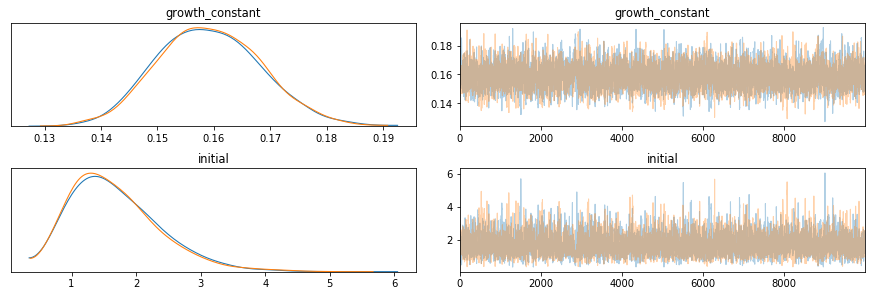

In [24]:
pm.traceplot(trace)
plt.show()

In [25]:
initial_array = np.array(trace['initial'])
growth_array = np.array(trace['growth_constant'])
doubling_array = np.log(2) / growth_array

Plot the histogram of doubling times.

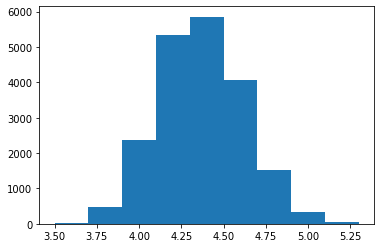

In [40]:
plt.hist(doubling_array, bins=np.arange(3.5, 5.4, 0.2))
plt.show()

In [27]:
final_array = initial_array * np.exp(growth_array * (num_days - 1))

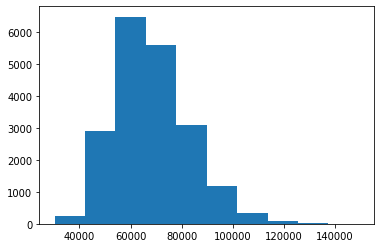

In [28]:
plt.hist(final_array)
plt.show()

This is the estimate if it's kept growing at the same rate for the past 3 weeks (unrealistically).

Plot the mean and some confidence intervals over time.

In [29]:
def get_array_at_t(time,
                   initial_array=initial_array,
                   growth_array=growth_array):
    array_at_t = initial_array * np.exp(growth_array * time)
    return array_at_t

In [30]:
def get_mean_at_t(time,
                  initial_array=initial_array,
                  growth_array=growth_array):
    array_at_t = get_array_at_t(time,
                                initial_array=initial_array,
                                growth_array=growth_array)
    return np.mean(array_at_t)

In [31]:
def get_percentile_at_t(time, percent,
                        initial_array=initial_array,
                        growth_array=growth_array):
    array_at_t = get_array_at_t(time,
                                initial_array=initial_array,
                                growth_array=growth_array)
    return np.percentile(array_at_t, q=percent)

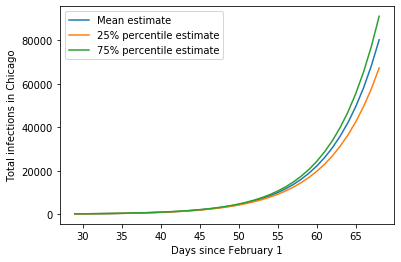

In [32]:
x = np.arange(29, 69)
y_mean = np.array([get_mean_at_t(time) for time in x])
y_25 = np.array([get_percentile_at_t(time, 25)
                  for time in x])
y_75 = np.array([get_percentile_at_t(time, 75)
                  for time in x])
plt.plot(x, y_mean, label='Mean estimate')
plt.plot(x, y_25, label='25% percentile estimate')
plt.plot(x, y_75, label='75% percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel('Total infections in Chicago')
plt.legend()
# plt.yscale('log')
plt.show()

This is still an unrealistic model, because it assumes that the growth keeps going forever.

Plot the first 17 days of March though. This should be fairly reliable.

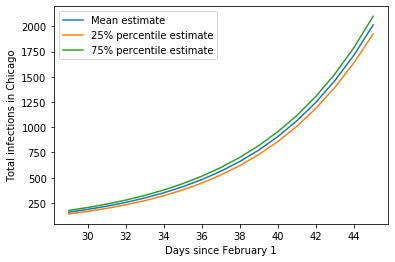

In [33]:
x = np.arange(29, 29 + 17)
y_mean = np.array([get_mean_at_t(time) for time in x])
y_25 = np.array([get_percentile_at_t(time, 25)
                  for time in x])
y_75 = np.array([get_percentile_at_t(time, 75)
                  for time in x])
plt.plot(x, y_mean, label='Mean estimate')
plt.plot(x, y_25, label='25% percentile estimate')
plt.plot(x, y_75, label='75% percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel('Total infections in Chicago')
plt.legend()
# plt.yscale('log')
plt.show()

Calculate the expected number of deaths.

In [36]:
Y = np.array([get_mean_at_t(time) for time in range(num_days)])

In [37]:
test = IFR * np.matmul(np.matmul(Y, 
                                 incubation_mat), 
                       delay_mat)

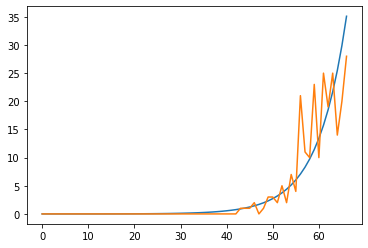

In [38]:
plt.plot(test)
plt.plot(death_list)
plt.show()

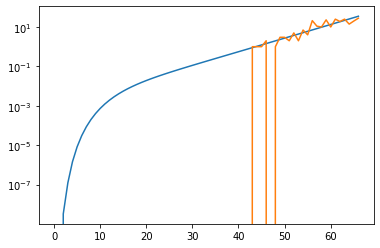

In [39]:
plt.plot(test)
plt.plot(death_list)
plt.yscale('log')
plt.show()

Looks like a good fit, but the last few days show signs that the slope has decreased.